In [4]:
# --------------------------------------------------
# TREC IS 2018 Evaluation Script
# Used to evaluate TREC-IS runs
# --------------------------------------------------
version = 1.0 # Notebook Version Number

# Configuration (Change this to match your setting)
# System output file to evaluate:
runFile = "../out/predict.txt.gz"
runName = "myrun"

# The location of the ground truth data against which to compare the run
classificationLabelFiles = [
    "assr1.test",
    "assr2.test",
    "assr3.test",
    "assr4.test",
    "assr5.test",
    "assr6.test"
]
classificationLabelFiles = ['../data/TRECIS-2018-TestEvents-Labels/' + filename for filename in classificationLabelFiles]

# The location of the ontology file
ontologyFile = "../data/" + "ITR-H.types.v2.json"

# --------------------------------------------------
# Static data for the 2018 edition
# --------------------------------------------------
# Identifiers for the test events
eventIdentifiers = [
    "albertaFloods2013",
    "australiaBushfire2013",
    "bostonBombings2013",
    "chileEarthquake2014",
    "flSchoolShooting2018",
    "guatemalaEarthquake2012",
    "italyEarthquakes2012",
    "joplinTornado2011",
    "manilaFloods2013",
    "nepalEarthquake2015",
    "parisAttacks2015",
    "philipinnesFloods2012",
    "queenslandFloods2013",
    "typhoonHagupit2014",
    "typhoonYolanda2013"
]

# Mapping of prority labels (by assessors) into numerical values [0-1]
# We use this to calculate error against the participant priority scores
priorityMapping = {
    "Critical" : 1.0,
    "High" : 0.75,
    "Medium" : 0.5,
    "Low" : 0.25
}

resultsFile = open(runName+".results.overall.txt","w+")
resultsFile.write("TREC-IS 2018 Notebook Evaluator v"+str(version)+"\n")
resultsFile.write("Run: "+runName+" ("+runFile+")"+"\n")
resultsFile.write(""+"\n")

perTopicFile = open(runName+".results.pertopic.txt","w+")
perTopicFile.write("TREC-IS 2018 Notebook Evaluator v"+str(version)+"\n")
perTopicFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perTopicFile.write(""+"\n")

perEventFile = open(runName+".results.perevent.txt","w+")
perEventFile.write("TREC-IS 2018 Notebook Evaluator v"+str(version)+"\n")
perEventFile.write("Run: "+runName+" ("+runFile+")"+"\n")
perEventFile.write(""+"\n")


# --------------------------------------------------
# Processing Starts Here
# --------------------------------------------------
import json
from pprint import pprint
import gzip

# --------------------------------------------------
# Stage 1: Load the ground truth dataset 
# --------------------------------------------------

groundtruthJSON = []
for groundtruthFile in classificationLabelFiles:
    print("Reading "+groundtruthFile)
    with open(groundtruthFile, encoding='utf-8') as groundtruthJSONFile:    
        groundtruthJSON.append(json.load(groundtruthJSONFile))
#pprint(groundtruthJSON["events"])

# --------------------------------------------------
# Stage 2: Load run file (assumes gzip)
# --------------------------------------------------
with gzip.open(runFile, 'rb') as openRunFile:
    runContents = openRunFile.readlines() # lines not yet decoded
#pprint(runContents[0])

# --------------------------------------------------
# Stage 3: Load the categories 
# --------------------------------------------------
with open(ontologyFile, encoding='utf-8') as ontologyJSONFile:    
    ontologyJSON = json.load(ontologyJSONFile)

informationTypes2Index = {} # category -> numerical index
informationTypesShort2Index = {} # category short form (e.g. Report-EmergingThreats vs. EmergingThreats) -> numerical index
informationTypeIndex = 0
for informationTypeJSON in ontologyJSON["informationTypes"]:
    informationTypeId = informationTypeJSON["id"]
    informationTypes2Index[informationTypeId] = informationTypeIndex
    informationTypesShort2Index[informationTypeId.split("-")[1]] = informationTypeIndex
    informationTypeIndex = informationTypeIndex + 1
    
# -----------------------------------------------------------
# Stage 4: Produce ground truth maps between tweetIds and categories
# -----------------------------------------------------------
# Notes: Ground truth is used as a base, if a run includes tweets
#        not in the ground truth they will be ignored
# Assumptions: A tweet will not be returned for multiple events

tweetId2InfoCategories = {} # tweet id -> Array of categories selected by assessors
tweetId2PriorityCategory = {} # tweet id -> priority label (Critical,High,Medium,Low)
index2TweetId = {} # ordered tweets
event2tweetIds = {} # event -> tweet ids for tweets within that event

tweetIndex = 0
for groundtruth in groundtruthJSON:
    for eventJSON in groundtruth["events"]:
        eventid = eventJSON["eventid"]
        
        # two events were split and assessed in parts, re-name these so they are correctly read
        if eventid.endswith("S1") | eventid.endswith("S2") | eventid.endswith("S3") | eventid.endswith("S4"):
            eventid = eventid[:-2]
        
        if not event2tweetIds.get(eventid):
            event2tweetIds[eventid] = []
        
        if any(eventid in s for s in eventIdentifiers):
            # iterate over tweets in the event
            for tweetJSON in eventJSON["tweets"]:
                tweetid = tweetJSON["postID"]
                categories = tweetJSON["categories"]
                priority = tweetJSON["priority"]
                
                event2tweetIds[eventid].append(tweetid)
                
                # check categories for name issues and correct if possible
                for categoryId in categories:
                    if not any(categoryId in s for s in informationTypesShort2Index.keys()):
                        print("Found unknown category "+categoryId)
    
                tweetId2InfoCategories[tweetid] = categories
                tweetId2PriorityCategory[tweetid] = priority
                index2TweetId[tweetIndex] = tweetid;
                tweetIndex = tweetIndex + 1
        else:
            print("WARN: Found ground truth data for event not in the 2018 topic set "+eventid+", ignoring...")
        
# -----------------------------------------------------------
# Stage 5: Produce run predicted maps between tweetIds and categories
# -----------------------------------------------------------
tweetId2RunInfoCategory = {} # tweet id -> predicted category by participant system
tweetId2RunPriorityCategory = {} # tweet id -> importance score from participant system

maxPrediction = -999999
minPrediction = 999999

for runLine in runContents:
    predictionParts = runLine.decode("utf-8").replace("\t", " ").split(" ")
    if (len(predictionParts)<6 ):
        continue
    else:
        tweetId = predictionParts[2]
        category = predictionParts[5]
        priority = predictionParts[4]
        
        priorityNum = float(priority)
        if (maxPrediction<priorityNum): 
            maxPrediction = priorityNum
        if (minPrediction>priorityNum):
            minPrediction = priorityNum
        
        tweetId2RunInfoCategory[tweetId] = category
        tweetId2RunPriorityCategory[tweetId] = priority
        
# --------------------------------------------------
# Stage 6: Create ground truth vectors per category
# --------------------------------------------------

category2GroundTruth = {} # category -> tweet vector with binary 1 vs all ground truth category labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2InfoCategories.get(tweetId)
        #pprint(categories)
        if any(categoryIdShort in s for s in categories):
            categoryVector.append(1)
        else:
            categoryVector.append(0)
    category2GroundTruth[categoryId] = categoryVector
            
#pprint(category2GroundTruth)

# --------------------------------------------------
# Stage 7: Create run vectors per category 
# --------------------------------------------------
# Assumptions: If run misses a tweet, we assume id has
#              no categories
category2Predicted = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        
        if tweetId2RunInfoCategory.get(tweetId):
            category = tweetId2RunInfoCategory.get(tweetId)
            if category == categoryId:
                categoryVector.append(1)
            else:
                categoryVector.append(0)
        else:
            categoryVector.append(0)

    category2Predicted[categoryId] = categoryVector

#pprint(category2Predicted)

# --------------------------------------------------
# Stage 8: Make event category vectors 
# --------------------------------------------------

event2groundtruth = {} # event -> category -> tweet vector with binary 1 vs all ground truth category labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        for tweetId in event2tweetIds.get(eventId):
            category = tweetId2RunInfoCategory.get(tweetId)
            if category == categoryId:
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2groundtruth[eventId] = eventCategories
    

event2prediction = {} # event -> category -> tweet vector with binary 1 vs all predicted by system labels
for eventId in eventIdentifiers:
    eventCategories = {}
    for categoryId in informationTypes2Index.keys():
        categoryIdShort = categoryId.split("-")[1]
        categoryVector = []
        for tweetId in event2tweetIds.get(eventId):
            categories = tweetId2InfoCategories.get(tweetId)
            if any(categoryIdShort in s for s in categories):
                categoryVector.append(1)
            else:
                categoryVector.append(0)
            
        eventCategories[categoryId] = categoryVector
    event2prediction[eventId] = eventCategories


# -----------------------------------------------------------
# Stage 9: Make priority classification vectors
# -----------------------------------------------------------

category2GroundTruthPriority = {} # category -> tweet vector with binary 1 vs all ground truth priority labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    priorityVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2InfoCategories.get(tweetId)
        if any(categoryIdShort in s for s in categories):
            priority = tweetId2PriorityCategory.get(tweetId)
            priorityAsNumber = priorityMapping[priority]
            priorityVector.append(priorityAsNumber)
    category2GroundTruthPriority[categoryId] = priorityVector

category2PredictedPriority = {} # category -> tweet vector with binary 1 vs all predicted by system labels

for categoryId in informationTypes2Index.keys():
    categoryIdShort = categoryId.split("-")[1]
    categoryVector = []
    for i in range(len(index2TweetId)):
        tweetId = index2TweetId[i]
        categories = tweetId2InfoCategories.get(tweetId)
        if any(categoryIdShort in s for s in categories):
            if tweetId2RunPriorityCategory.get(tweetId):
                priority = float(tweetId2RunPriorityCategory.get(tweetId))
                
                # scale to between 0 and 1
                if (maxPrediction-minPrediction)>0:
                    normPriority = (priority-minPrediction)/(maxPrediction-minPrediction)
                else:
                    normPriority = 0.0;
                # bound by min and max on ground truth
                if (normPriority<priorityMapping["Low"]): 
                    normPriority = priorityMapping["Low"]
                if (normPriority>priorityMapping["Critical"]): 
                    normPriority = priorityMapping["Critical"]
                
                categoryVector.append(normPriority)
            else:
                categoryVector.append(priorityMapping["Low"]) # default to low priority

    category2PredictedPriority[categoryId] = categoryVector


    

Reading ../data/TRECIS-2018-TestEvents-Labels/assr1.test
Reading ../data/TRECIS-2018-TestEvents-Labels/assr2.test
Reading ../data/TRECIS-2018-TestEvents-Labels/assr3.test
Reading ../data/TRECIS-2018-TestEvents-Labels/assr4.test
Reading ../data/TRECIS-2018-TestEvents-Labels/assr5.test
Reading ../data/TRECIS-2018-TestEvents-Labels/assr6.test
WARN: Found ground truth data for event not in the 2018 topic set fireColorado2012, ignoring...


In [2]:
# --------------------------------------------------
# Disable Warnings (comment this out when debugging!)
# --------------------------------------------------
import warnings
warnings.filterwarnings("ignore") # ignore warnings about 0-score categories

In [5]:
# --------------------------------------------------
# EVALUATON 1: Information Type Categorization (Multi-type)
# Overall performance
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Average performance over information types
# Macro averaged (information types have equal weight)
# Positive class is the target class

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

avgPrecision = 0.0
avgRecall = 0.0
avgF1 = 0.0
avgAccuracy = 0.0

for categoryId in informationTypes2Index.keys():
    avgPrecision = avgPrecision + precision_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    avgRecall = avgRecall + recall_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    avgF1 = avgF1 + f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary')
    avgAccuracy = avgAccuracy + accuracy_score(category2GroundTruth[categoryId], category2Predicted[categoryId])

print("Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/len(informationTypes2Index)))
print("Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/len(informationTypes2Index)))
print("Information Type F1 (positive class, multi-type, macro): "+str(avgF1/len(informationTypes2Index)))
print("Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/len(informationTypes2Index)))

resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
resultsFile.write("Overall performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Information Type Precision (positive class, multi-type, macro):"+"\t"+str(avgPrecision/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Recall (positive class, multi-type, macro):"+"\t"+str(avgRecall/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type F1 (positive class, multi-type, macro):"+"\t"+str(avgF1/len(informationTypes2Index))+"\n")
resultsFile.write("> Information Type Accuracy (overall, multi-type, macro):"+"\t"+str(avgAccuracy/len(informationTypes2Index))+"\n")
resultsFile.write(""+"\n")

/Users/jpzhou/Virtualenv/Twitter/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/jpzhou/Virtualenv/Twitter/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Information Type Precision (positive class, multi-type, macro): 0.0
Information Type Recall (positive class, multi-type, macro): 0.0
Information Type F1 (positive class, multi-type, macro): 0.0
Information Type Accuracy (overall, multi-type, macro): 0.9122300849171049


1

In [4]:
# --------------------------------------------------
# EVALUATON 2: Information Type Categorization (Multi-type)
# Per Information Type Performance
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Performance on the target class is what we care about here, 
# primaraly with respect to recall, as we want the user to 
# see all of the information for a given category. A small
# amount of noise being added to the feed is an acceptable
# cost for good recall.

from sklearn.metrics import classification_report

perTopicFile.write("--------------------------------------------------"+"\n")
perTopicFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perTopicFile.write("Per Information Type Performance"+"\n")
perTopicFile.write("--------------------------------------------------"+"\n")

for categoryId in informationTypes2Index.keys():
    target_names = ['Other Classes', categoryId]
    print(categoryId)
    print(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names))


    perTopicFile.write(categoryId+"\n")
    perTopicFile.write(classification_report(category2GroundTruth[categoryId], category2Predicted[categoryId], target_names=target_names)+"\n")
    perTopicFile.write(""+"\n")

perTopicFile.write(""+"\n")
    

Request-GoodsServices
                       precision    recall  f1-score   support

        Other Classes       0.99      1.00      1.00     19658
Request-GoodsServices       0.19      0.12      0.15       126

          avg / total       0.99      0.99      0.99     19784

Request-SearchAndRescue
                         precision    recall  f1-score   support

          Other Classes       0.99      0.99      0.99     19498
Request-SearchAndRescue       0.11      0.11      0.11       286

            avg / total       0.97      0.97      0.97     19784

Request-InformationWanted
                           precision    recall  f1-score   support

            Other Classes       0.99      0.99      0.99     19612
Request-InformationWanted       0.00      0.00      0.00       172

              avg / total       0.98      0.99      0.98     19784

CallToAction-Volunteer
                        precision    recall  f1-score   support

         Other Classes       0.99      1.00      1.

1

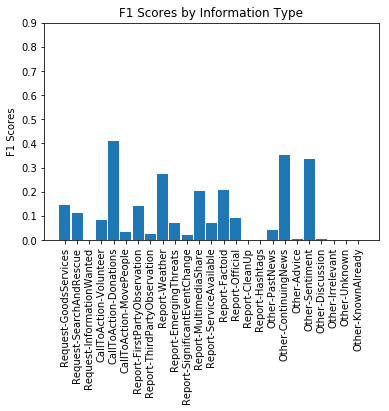

In [12]:
# --------------------------------------------------
# EVALUATON 3: Information Type Categorization (Multi-type)
# Per Information Type F1 Graph
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# F1 scores for each information type, graphed

import numpy as np
import matplotlib.pyplot as plt

N = len(informationTypes2Index)
ind = np.arange(N)

scoresPerCategoryF1 = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    scoresPerCategoryF1.append(f1_score(category2GroundTruth[categoryId], category2Predicted[categoryId], average='binary'))
    categoryLabels.append(categoryId)
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerCategoryF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Scores by Information Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [6]:
# --------------------------------------------------
# EVALUATON 4: Information Type Categorization (Multi-type)
# Per Event Performance
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Macro average (categories have equal weight)

perEventFile.write("--------------------------------------------------"+"\n")
perEventFile.write("EVALUATON: Information Type Categorization (Multi-type)"+"\n")
perEventFile.write("Per Event Performance"+"\n")
perEventFile.write("--------------------------------------------------"+"\n")

for eventId in eventIdentifiers:
    avgPrecision = 0.0
    avgRecall = 0.0
    avgF1 = 0.0
    avgAccuracy = 0.0

    for categoryId in informationTypes2Index.keys():
        avgPrecision = avgPrecision + precision_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        avgRecall = avgRecall + recall_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        avgF1 = avgF1 + f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        avgAccuracy = avgAccuracy + accuracy_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId))
        
    print(eventId)
    print("  Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/len(informationTypes2Index)))
    print("  Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/len(informationTypes2Index)))
    print("  Information Type F1 (positive class, multi-type, macro): "+str(avgF1/len(informationTypes2Index)))
    print("  Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/len(informationTypes2Index)))
    print("")
    
    perEventFile.write(eventId+"\n")
    perEventFile.write("  Information Type Precision (positive class, multi-type, macro): "+str(avgPrecision/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Recall (positive class, multi-type, macro): "+str(avgRecall/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type F1 (positive class, multi-type, macro): "+str(avgF1/len(informationTypes2Index))+"\n")
    perEventFile.write("  Information Type Accuracy (overall, multi-type, macro): "+str(avgAccuracy/len(informationTypes2Index))+"\n")
    perEventFile.write("\n")
    
perEventFile.write("\n")

albertaFloods2013
  Information Type Precision (positive class, multi-type, macro): 0.07365575802056376
  Information Type Recall (positive class, multi-type, macro): 0.19115527950310562
  Information Type F1 (positive class, multi-type, macro): 0.07937887370042784
  Information Type Accuracy (overall, multi-type, macro): 0.8906371191135736

australiaBushfire2013
  Information Type Precision (positive class, multi-type, macro): 0.10475038007146932
  Information Type Recall (positive class, multi-type, macro): 0.19687549566805657
  Information Type F1 (positive class, multi-type, macro): 0.11287706602055987
  Information Type Accuracy (overall, multi-type, macro): 0.8903397341211224

bostonBombings2013
  Information Type Precision (positive class, multi-type, macro): 0.0762948891677856
  Information Type Recall (positive class, multi-type, macro): 0.1388153911524691
  Information Type F1 (positive class, multi-type, macro): 0.07208958363371326
  Information Type Accuracy (overall, multi

1

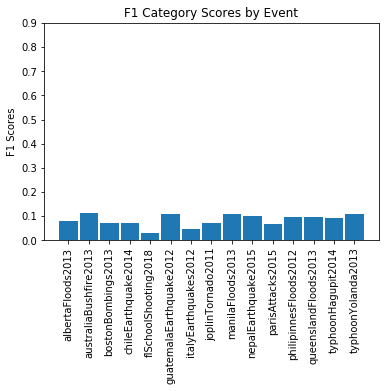

In [7]:
# --------------------------------------------------
# EVALUATON 5: Information Type Categorization (Multi-type)
# Per Event F1 Graph
# --------------------------------------------------
# Multi-type (1 vs All): Tweets have multiple information types, aim: predict all of them
# Macro average (categories have equal weight)

N = len(eventIdentifiers)
ind = np.arange(N)

scoresPerEventF1 = []
for eventId in eventIdentifiers:
    avgF1 = 0.0

    for categoryId in informationTypes2Index.keys():
        avgF1 = avgF1 + f1_score(event2groundtruth[eventId].get(categoryId), event2prediction[eventId].get(categoryId), average='binary')
        
    scoresPerEventF1.append(avgF1/len(informationTypes2Index))
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, scoresPerEventF1, width)

plt.ylabel('F1 Scores')
plt.title('F1 Category Scores by Event')
plt.xticks(ind, eventIdentifiers, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [8]:
# --------------------------------------------------
# EVALUATON 6: Information Priority Level
# Overall Performance
# --------------------------------------------------
# Average error over information types, lower is better
# Macro average (categories have equal weight)

from sklearn.metrics import mean_squared_error

avgMSE = 0.0;
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]
    
    error = mean_squared_error(groundTruthPriorities, predictedPriorities)
    avgMSE = avgMSE + error;
    
print("Priority Estimation Error (mean squared error, macro): "+str(avgMSE/len(informationTypes2Index)))
    
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Priority Level"+"\n")
resultsFile.write("Overall Performance"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Priority Estimation Error (mean squared error, macro): "+str(avgMSE/len(informationTypes2Index))+"\n")
resultsFile.write("\n")

Priority Estimation Error (mean squared error, macro): 0.09162717952926704


1

In [ ]:
# --------------------------------------------------
# EVALUATON 7: Information Priority Level
# Per Information Type Performance
# --------------------------------------------------
# Error per information type, lower is better

N = len(informationTypes2Index)
ind = np.arange(N)

mseValues = []
categoryLabels = []
for categoryId in informationTypes2Index.keys():
    groundTruthPriorities = category2GroundTruthPriority[categoryId]
    predictedPriorities = category2PredictedPriority[categoryId]
    error = mean_squared_error(groundTruthPriorities, predictedPriorities)
    categoryLabels.append(categoryId)
    mseValues.append(error);
    
width = 0.90       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, mseValues, width)

plt.ylabel('MSE Scores (lower is better)')
plt.title('Mean Squared Error on Predicted Priority Levels Per Type')
plt.xticks(ind, categoryLabels, rotation='vertical')
plt.yticks(np.arange(0, 1, 0.1))

plt.show()

In [10]:
# --------------------------------------------------
# EVALUATON 8: Information Type Categorization (Any-type)
# Overall Performance (Micro Average)
# --------------------------------------------------
# Any-type: Tweets have multiple information types, aim: predict any one of them
# Categorization performance where a system gets full
# score if it picked any of the information types that 
# the human assessor selected.
# Micro Average (more common information types have higher weight)

truePositive = 0 # system predicted any of the categories selected by the human assessor
trueNegative = 0 # system and human assessor both selected either Other-Irrelevant or Other-Unknown
falsePositive = 0 # system failed to predict any of the categories selected by the human assessor
falseNegative = 0 # human assessor selected either Other-Irrelevant or Other-Unknown but the system prediced something different

for i in range(len(index2TweetId)):
    tweetId = index2TweetId[i]
    
    groundTruthCategories = tweetId2InfoCategories.get(tweetId)
    predictedCategory = tweetId2RunInfoCategory.get(tweetId).split("-")[1]
    
    categoryMatchFound = False
    
    isNegativeExample = False
    if (predictedCategory == "Irrelevant") | (predictedCategory == "Unknown"):
        isNegativeExample = True;
    
    for groundTruthCategory in groundTruthCategories:
        if (groundTruthCategory == predictedCategory):
            categoryMatchFound = True

    if categoryMatchFound & isNegativeExample:
        trueNegative = trueNegative + 1
    if categoryMatchFound & (not isNegativeExample):
        truePositive = truePositive + 1
    if (not categoryMatchFound) & isNegativeExample:
        falseNegative = falseNegative + 1
    if (not categoryMatchFound) & (not isNegativeExample):
        falsePositive = falsePositive + 1
        
#print (str(truePositive)+" "+str(trueNegative)+" "+str(falsePositive)+" "+str(falseNegative))
        
precision = truePositive / (truePositive+falsePositive)
recall = truePositive / (truePositive+falseNegative)

print("Information Type Precision (any valid type, micro): " + str(precision)) 
print("Information Type Recall (any valid type, micro): " + str(recall))

f1 = 2 * ( ( precision * recall ) / ( precision + recall ) )
accuracy = (truePositive + trueNegative) / (truePositive + trueNegative + falsePositive + falseNegative)


print("Information Type F1 (any valid type, micro): " + str(f1))
print("Information Type Accuracy (any valid type, micro): " + str(accuracy))


resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("EVALUATON: Information Type Categorization (Any-type)"+"\n")
resultsFile.write("Overall Performance (Micro Average)"+"\n")
resultsFile.write("--------------------------------------------------"+"\n")
resultsFile.write("> Information Type Precision (any valid type, micro): " + str(precision)+"\n")
resultsFile.write("> Information Type Recall (any valid type, micro): " + str(recall)+"\n")
resultsFile.write("> Information Type F1 (any valid type, micro): " + str(f1)+"\n")
resultsFile.write("> Information Type Accuracy (any valid type, micro): " + str(accuracy)+"\n")

Information Type Precision (any valid type, micro): 0.31358673675697535
Information Type Recall (any valid type, micro): 1.0
Information Type F1 (any valid type, micro): 0.47745113129136524
Information Type Accuracy (any valid type, micro): 0.31358673675697535


73

In [11]:
# Done
resultsFile.close() 
perTopicFile.close()
perEventFile.close()